In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
from IPython.display import HTML


import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = P2_GLOBAL #to be equivalent/same importance as having 0 stock or surpassing max capacity levels


## System initializer

In [3]:
def initialize_test_system(seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = True
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
#     for i, (lvl, max_load) in enumerate(zip(n_discrete_load_levels, tank_max_loads)):
#         a = np.linspace(0,max_load, lvl+1)[1]
#         current_load = np.random.randint(a+1,max_load)
#         tank_current_loads[i] = current_load     

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

368640

In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print(system.tank_loads())
print(system.graph)
print(system.weights)

[35, 171, 67, 429, 42]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
[[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

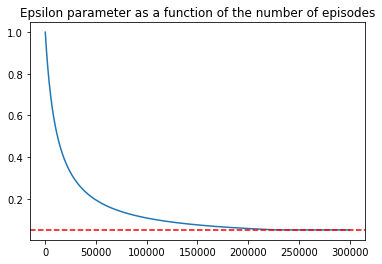

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 3*10**5
episodes_epsilon_min = 0.04*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  10**3
train_rew_freq =  10**2
train_Q_freq =  10**3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 14

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [7]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

# Create directories for the simulations' outputs

simulation_directory = './simulations/simulation{}'.format(simulation_id)
if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    os.makedirs(simulation_directory + '/Q-dictionaries')
    os.makedirs(simulation_directory + '/discrewards')
    os.makedirs(simulation_directory + '/vis')
    
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")

    
ut.save_obj(toy_system, simulation_directory+"/system-sim"+f"{simulation_id}") 

In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode}")   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{episode}")   
                                
        if episode % rew_freq == 0:
                rewards_list.append(discounted_reward);
                ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                
    end_time = round(time.time()-time_start,round_time)        
    print(f"Training finished. Total episodes: {n_episodes}. Elapsed time: {round(end_time/60., round_time)} minutes.")        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

Episode: 100. Elapsed time  0.05  minuts. epsilon 0.9918 Discounted reward:  -8662111.607445398
Episode: 200. Elapsed time  0.12  minuts. epsilon 0.9837 Discounted reward:  -8597568.312087744
Episode: 300. Elapsed time  0.19  minuts. epsilon 0.9757 Discounted reward:  -7241482.211825967
Episode: 400. Elapsed time  0.27  minuts. epsilon 0.9678 Discounted reward:  -7580185.079477649
Episode: 500. Elapsed time  0.37  minuts. epsilon 0.9601 Discounted reward:  -8842102.192341417
Episode: 600. Elapsed time  0.46  minuts. epsilon 0.9525 Discounted reward:  -8211861.012427437
Episode: 700. Elapsed time  0.56  minuts. epsilon 0.945 Discounted reward:  -8896062.817336274
Episode: 800. Elapsed time  0.67  minuts. epsilon 0.9376 Discounted reward:  -6615911.6603824645
Episode: 900. Elapsed time  0.78  minuts. epsilon 0.9303 Discounted reward:  -6233749.3853852
Episode: 1000. Elapsed time  0.89  minuts. epsilon 0.9231 Discounted reward:  -8736348.089337606
Episode: 1100. Elapsed time  1.02  minuts

Episode: 8600. Elapsed time  18.5  minuts. epsilon 0.5826 Discounted reward:  -5377896.456396648
Episode: 8700. Elapsed time  18.81  minuts. epsilon 0.5797 Discounted reward:  -3694458.181207844
Episode: 8800. Elapsed time  19.12  minuts. epsilon 0.577 Discounted reward:  -8524185.896583458
Episode: 8900. Elapsed time  19.41  minuts. epsilon 0.5742 Discounted reward:  -6011589.032760678
Episode: 9000. Elapsed time  19.7  minuts. epsilon 0.5715 Discounted reward:  -6696589.735089791
Episode: 9100. Elapsed time  20.02  minuts. epsilon 0.5687 Discounted reward:  -5186580.39348386
Episode: 9200. Elapsed time  20.33  minuts. epsilon 0.5661 Discounted reward:  -5313819.69513216
Episode: 9300. Elapsed time  20.65  minuts. epsilon 0.5634 Discounted reward:  -3753945.186134696
Episode: 9400. Elapsed time  20.97  minuts. epsilon 0.5608 Discounted reward:  -5042952.648692135
Episode: 9500. Elapsed time  21.28  minuts. epsilon 0.5582 Discounted reward:  -6698712.406209529
Episode: 9600. Elapsed ti

Episode: 25200. Elapsed time  79.35  minuts. epsilon 0.3226 Discounted reward:  -1742763.784102723
Episode: 25300. Elapsed time  79.76  minuts. epsilon 0.3217 Discounted reward:  -3326592.7833175366
Episode: 25400. Elapsed time  80.2  minuts. epsilon 0.3209 Discounted reward:  -1679599.4707814874
Episode: 25500. Elapsed time  80.6  minuts. epsilon 0.32 Discounted reward:  -2566907.933643159
Episode: 25600. Elapsed time  81.04  minuts. epsilon 0.3192 Discounted reward:  -6897562.511298019
Episode: 25700. Elapsed time  81.45  minuts. epsilon 0.3183 Discounted reward:  -1278517.6273185129
Episode: 25800. Elapsed time  81.85  minuts. epsilon 0.3175 Discounted reward:  -3632900.578585265
Episode: 25900. Elapsed time  82.29  minuts. epsilon 0.3166 Discounted reward:  -3522965.114805122
Episode: 26000. Elapsed time  82.7  minuts. epsilon 0.3158 Discounted reward:  -88629.76921214517
Episode: 26100. Elapsed time  83.14  minuts. epsilon 0.315 Discounted reward:  -1898297.7392910281
Episode: 262

Episode: 33500. Elapsed time  114.71  minuts. epsilon 0.2637 Discounted reward:  -1328318.1889710694
Episode: 33600. Elapsed time  115.13  minuts. epsilon 0.2632 Discounted reward:  -1823375.189046306
Episode: 33700. Elapsed time  115.59  minuts. epsilon 0.2626 Discounted reward:  -744278.2668489846
Episode: 33800. Elapsed time  116.01  minuts. epsilon 0.262 Discounted reward:  -1907647.4620736868
Episode: 33900. Elapsed time  116.43  minuts. epsilon 0.2614 Discounted reward:  -1309973.8418630278
Episode: 34000. Elapsed time  116.88  minuts. epsilon 0.2609 Discounted reward:  -2824716.809905865
Episode: 34100. Elapsed time  117.32  minuts. epsilon 0.2603 Discounted reward:  -1561851.6257472453
Episode: 34200. Elapsed time  117.74  minuts. epsilon 0.2597 Discounted reward:  -1312730.3431396277
Episode: 34300. Elapsed time  118.16  minuts. epsilon 0.2592 Discounted reward:  -2302584.2542165066
Episode: 34400. Elapsed time  118.6  minuts. epsilon 0.2586 Discounted reward:  -2627621.191991

Episode: 41700. Elapsed time  150.98  minuts. epsilon 0.2235 Discounted reward:  -1078964.6530093625
Episode: 41800. Elapsed time  151.46  minuts. epsilon 0.2231 Discounted reward:  -896518.3151783423
Episode: 41900. Elapsed time  151.93  minuts. epsilon 0.2226 Discounted reward:  -182186.5552602702
Episode: 42000. Elapsed time  152.4  minuts. epsilon 0.2222 Discounted reward:  -193366.45162120444
Episode: 42100. Elapsed time  152.86  minuts. epsilon 0.2218 Discounted reward:  -2199978.454773347
Episode: 42200. Elapsed time  153.31  minuts. epsilon 0.2214 Discounted reward:  -4219330.35223637
Episode: 42300. Elapsed time  153.77  minuts. epsilon 0.221 Discounted reward:  -4092988.9110106914
Episode: 42400. Elapsed time  154.21  minuts. epsilon 0.2206 Discounted reward:  -1404696.8290305997
Episode: 42500. Elapsed time  154.68  minuts. epsilon 0.2202 Discounted reward:  -1612968.6974929003
Episode: 42600. Elapsed time  155.12  minuts. epsilon 0.2198 Discounted reward:  -1678475.15071475

Episode: 49900. Elapsed time  188.94  minuts. epsilon 0.1939 Discounted reward:  -956593.796750183
Episode: 50000. Elapsed time  189.41  minuts. epsilon 0.1936 Discounted reward:  -3190728.1755804815
Episode: 50100. Elapsed time  189.9  minuts. epsilon 0.1932 Discounted reward:  -1308677.2569062659
Episode: 50200. Elapsed time  190.37  minuts. epsilon 0.1929 Discounted reward:  -2654216.76169272
Episode: 50300. Elapsed time  190.87  minuts. epsilon 0.1926 Discounted reward:  -3408379.199315645
Episode: 50400. Elapsed time  191.34  minuts. epsilon 0.1923 Discounted reward:  -3287226.09622072
Episode: 50500. Elapsed time  191.82  minuts. epsilon 0.192 Discounted reward:  -1642113.1717186563
Episode: 50600. Elapsed time  192.27  minuts. epsilon 0.1917 Discounted reward:  -663989.3003802085
Episode: 50700. Elapsed time  192.73  minuts. epsilon 0.1914 Discounted reward:  -3768230.386334065
Episode: 50800. Elapsed time  193.18  minuts. epsilon 0.1911 Discounted reward:  -4454241.047527286
Ep

Episode: 58100. Elapsed time  233.98  minuts. epsilon 0.1712 Discounted reward:  -1732733.3214327975
Episode: 58200. Elapsed time  234.65  minuts. epsilon 0.1709 Discounted reward:  -648395.8514414104
Episode: 58300. Elapsed time  235.34  minuts. epsilon 0.1707 Discounted reward:  -336282.21097451984
Episode: 58400. Elapsed time  235.94  minuts. epsilon 0.1705 Discounted reward:  -608105.0912333201
Episode: 58500. Elapsed time  236.59  minuts. epsilon 0.1702 Discounted reward:  -3079847.638073558
Episode: 58600. Elapsed time  237.2  minuts. epsilon 0.17 Discounted reward:  -211867.69413989136
Episode: 58700. Elapsed time  237.8  minuts. epsilon 0.1697 Discounted reward:  -2133976.7525889566
Episode: 58800. Elapsed time  238.31  minuts. epsilon 0.1695 Discounted reward:  -2243615.193222942
Episode: 58900. Elapsed time  238.79  minuts. epsilon 0.1693 Discounted reward:  -529903.5215217727
Episode: 59000. Elapsed time  239.3  minuts. epsilon 0.169 Discounted reward:  -1038040.1207868624
E

Episode: 66300. Elapsed time  276.64  minuts. epsilon 0.1533 Discounted reward:  -727954.265163789
Episode: 66400. Elapsed time  277.12  minuts. epsilon 0.1531 Discounted reward:  -229861.75793910126
Episode: 66500. Elapsed time  277.63  minuts. epsilon 0.1529 Discounted reward:  -185302.548205701
Episode: 66600. Elapsed time  278.11  minuts. epsilon 0.1527 Discounted reward:  -1404791.3912255678
Episode: 66700. Elapsed time  278.59  minuts. epsilon 0.1525 Discounted reward:  -1178638.5426530973
Episode: 66800. Elapsed time  279.06  minuts. epsilon 0.1523 Discounted reward:  0.00204995518860029
Episode: 66900. Elapsed time  279.58  minuts. epsilon 0.1521 Discounted reward:  -890198.805774552
Episode: 67000. Elapsed time  280.12  minuts. epsilon 0.1519 Discounted reward:  -1146717.780967599
Episode: 67100. Elapsed time  280.61  minuts. epsilon 0.1517 Discounted reward:  -926195.925248101
Episode: 67200. Elapsed time  281.14  minuts. epsilon 0.1515 Discounted reward:  -1879446.2681954382

Episode: 74500. Elapsed time  319.17  minuts. epsilon 0.1387 Discounted reward:  -1301723.2348842653
Episode: 74600. Elapsed time  319.68  minuts. epsilon 0.1386 Discounted reward:  -510259.60105855326
Episode: 74700. Elapsed time  320.19  minuts. epsilon 0.1384 Discounted reward:  -586987.484868733
Episode: 74800. Elapsed time  320.74  minuts. epsilon 0.1383 Discounted reward:  -150094.63471761777
Episode: 74900. Elapsed time  321.3  minuts. epsilon 0.1381 Discounted reward:  -669850.5775100187
Episode: 75000. Elapsed time  321.78  minuts. epsilon 0.1379 Discounted reward:  -1344660.4981615504
Episode: 75100. Elapsed time  322.27  minuts. epsilon 0.1378 Discounted reward:  -1535775.868989828
Episode: 75200. Elapsed time  322.76  minuts. epsilon 0.1376 Discounted reward:  -582619.3213651055
Episode: 75300. Elapsed time  323.24  minuts. epsilon 0.1375 Discounted reward:  -726099.6283746111
Episode: 75400. Elapsed time  323.81  minuts. epsilon 0.1373 Discounted reward:  -2912459.70551319

Episode: 82700. Elapsed time  361.84  minuts. epsilon 0.1267 Discounted reward:  -459163.0416454815
Episode: 82800. Elapsed time  362.39  minuts. epsilon 0.1266 Discounted reward:  -723736.2014750427
Episode: 82900. Elapsed time  362.99  minuts. epsilon 0.1265 Discounted reward:  -541104.470773008
Episode: 83000. Elapsed time  363.48  minuts. epsilon 0.1263 Discounted reward:  0.0023826648743392347
Episode: 83100. Elapsed time  364.06  minuts. epsilon 0.1262 Discounted reward:  -3889039.2253253036
Episode: 83200. Elapsed time  364.6  minuts. epsilon 0.1261 Discounted reward:  -3412928.6268256865
Episode: 83300. Elapsed time  365.11  minuts. epsilon 0.1259 Discounted reward:  -1260567.0420776906
Episode: 83400. Elapsed time  365.6  minuts. epsilon 0.1258 Discounted reward:  -1020957.8340392293
Episode: 83500. Elapsed time  366.15  minuts. epsilon 0.1257 Discounted reward:  -1133600.5462022156
Episode: 83600. Elapsed time  366.64  minuts. epsilon 0.1255 Discounted reward:  -1003609.40311

Episode: 90900. Elapsed time  404.68  minuts. epsilon 0.1166 Discounted reward:  -205891.31596449763
Episode: 91000. Elapsed time  405.17  minuts. epsilon 0.1165 Discounted reward:  -1009504.1836619792
Episode: 91100. Elapsed time  405.67  minuts. epsilon 0.1164 Discounted reward:  -895274.9540189925
Episode: 91200. Elapsed time  406.18  minuts. epsilon 0.1163 Discounted reward:  -413289.3670641026
Episode: 91300. Elapsed time  406.75  minuts. epsilon 0.1162 Discounted reward:  -1228081.3407219157
Episode: 91400. Elapsed time  407.26  minuts. epsilon 0.1161 Discounted reward:  -116299.4717929125
Episode: 91500. Elapsed time  407.75  minuts. epsilon 0.1159 Discounted reward:  -721823.7639491648
Episode: 91600. Elapsed time  408.28  minuts. epsilon 0.1158 Discounted reward:  -666526.3044150599
Episode: 91700. Elapsed time  408.78  minuts. epsilon 0.1157 Discounted reward:  -88629.37912887013
Episode: 91800. Elapsed time  409.28  minuts. epsilon 0.1156 Discounted reward:  -166771.98245948

Episode: 99100. Elapsed time  447.75  minuts. epsilon 0.108 Discounted reward:  -1021576.6518016035
Episode: 99200. Elapsed time  448.28  minuts. epsilon 0.1079 Discounted reward:  -2576593.798970981
Episode: 99300. Elapsed time  448.77  minuts. epsilon 0.1078 Discounted reward:  -708700.3826557882
Episode: 99400. Elapsed time  449.26  minuts. epsilon 0.1077 Discounted reward:  -387420.4875556743
Episode: 99500. Elapsed time  449.81  minuts. epsilon 0.1076 Discounted reward:  -629999.6810766757
Episode: 99600. Elapsed time  450.3  minuts. epsilon 0.1075 Discounted reward:  -1363503.8614458304
Episode: 99700. Elapsed time  450.79  minuts. epsilon 0.1074 Discounted reward:  -116299.47272047804
Episode: 99800. Elapsed time  451.29  minuts. epsilon 0.1073 Discounted reward:  -451141.693641008
Episode: 99900. Elapsed time  451.78  minuts. epsilon 0.1072 Discounted reward:  -2377725.140258624
Episode: 100000. Elapsed time  452.3  minuts. epsilon 0.1071 Discounted reward:  -852398.8009272047


Episode: 107200. Elapsed time  491.01  minuts. epsilon 0.1007 Discounted reward:  -470481.8249621371
Episode: 107300. Elapsed time  491.58  minuts. epsilon 0.1006 Discounted reward:  -104669.58083834738
Episode: 107400. Elapsed time  492.08  minuts. epsilon 0.1005 Discounted reward:  -47101.408160033956
Episode: 107500. Elapsed time  492.58  minuts. epsilon 0.1004 Discounted reward:  0.001658049176458423
Episode: 107600. Elapsed time  493.08  minuts. epsilon 0.1003 Discounted reward:  0.002079900907594326
Episode: 107700. Elapsed time  493.6  minuts. epsilon 0.1003 Discounted reward:  -478296.8978322949
Episode: 107800. Elapsed time  494.2  minuts. epsilon 0.1002 Discounted reward:  -124124.91021249982
Episode: 107900. Elapsed time  494.7  minuts. epsilon 0.1001 Discounted reward:  -706217.9479858804
Episode: 108000. Elapsed time  495.2  minuts. epsilon 0.1 Discounted reward:  -585480.6726531846
Episode: 108100. Elapsed time  495.72  minuts. epsilon 0.0999 Discounted reward:  -627621.5

Episode: 115300. Elapsed time  533.76  minuts. epsilon 0.0943 Discounted reward:  -226545.79979924727
Episode: 115400. Elapsed time  534.26  minuts. epsilon 0.0942 Discounted reward:  -1342708.301204106
Episode: 115500. Elapsed time  534.75  minuts. epsilon 0.0941 Discounted reward:  -214851.61341000078
Episode: 115600. Elapsed time  535.25  minuts. epsilon 0.094 Discounted reward:  -1035085.1700102636
Episode: 115700. Elapsed time  535.75  minuts. epsilon 0.094 Discounted reward:  -421536.030076804
Episode: 115800. Elapsed time  536.26  minuts. epsilon 0.0939 Discounted reward:  -740585.2260938078
Episode: 115900. Elapsed time  536.76  minuts. epsilon 0.0938 Discounted reward:  -2442589.9377000653
Episode: 116000. Elapsed time  537.35  minuts. epsilon 0.0938 Discounted reward:  -910286.5851523923
Episode: 116100. Elapsed time  537.85  minuts. epsilon 0.0937 Discounted reward:  -579444.359556512
Episode: 116200. Elapsed time  538.35  minuts. epsilon 0.0936 Discounted reward:  -301303.4

Episode: 123400. Elapsed time  576.53  minuts. epsilon 0.0886 Discounted reward:  -786616.1933577295
Episode: 123500. Elapsed time  577.08  minuts. epsilon 0.0886 Discounted reward:  -3022199.9976668116
Episode: 123600. Elapsed time  577.59  minuts. epsilon 0.0885 Discounted reward:  -1999999.9978348843
Episode: 123700. Elapsed time  578.09  minuts. epsilon 0.0884 Discounted reward:  -47101.34908246978
Episode: 123800. Elapsed time  578.69  minuts. epsilon 0.0884 Discounted reward:  -728999.9978809365
Episode: 123900. Elapsed time  579.2  minuts. epsilon 0.0883 Discounted reward:  -508997.5177051274
Episode: 124000. Elapsed time  579.69  minuts. epsilon 0.0882 Discounted reward:  -313810.6465956114
Episode: 124100. Elapsed time  580.33  minuts. epsilon 0.0882 Discounted reward:  -178243.62934341244
Episode: 124200. Elapsed time  580.84  minuts. epsilon 0.0881 Discounted reward:  0.0016898344472553505
Episode: 124300. Elapsed time  581.38  minuts. epsilon 0.088 Discounted reward:  -3283

Episode: 131500. Elapsed time  620.28  minuts. epsilon 0.0836 Discounted reward:  -1409873.5531218187
Episode: 131600. Elapsed time  620.78  minuts. epsilon 0.0836 Discounted reward:  -2520001.734054799
Episode: 131700. Elapsed time  621.32  minuts. epsilon 0.0835 Discounted reward:  -2049023.9281640546
Episode: 131800. Elapsed time  621.84  minuts. epsilon 0.0834 Discounted reward:  -656099.9978288129
Episode: 131900. Elapsed time  622.46  minuts. epsilon 0.0834 Discounted reward:  0.0014680339098236638
Episode: 132000. Elapsed time  623.02  minuts. epsilon 0.0833 Discounted reward:  0.0022708199309583554
Episode: 132100. Elapsed time  623.57  minuts. epsilon 0.0833 Discounted reward:  -0.9370900873119267
Episode: 132200. Elapsed time  624.1  minuts. epsilon 0.0832 Discounted reward:  -537533.504028113
Episode: 132300. Elapsed time  624.63  minuts. epsilon 0.0832 Discounted reward:  -576774.0757245028
Episode: 132400. Elapsed time  625.14  minuts. epsilon 0.0831 Discounted reward:  -3

Episode: 139600. Elapsed time  664.08  minuts. epsilon 0.0792 Discounted reward:  -432524.2233357397
Episode: 139700. Elapsed time  664.66  minuts. epsilon 0.0791 Discounted reward:  -1541179.9089282372
Episode: 139800. Elapsed time  665.19  minuts. epsilon 0.0791 Discounted reward:  -64610.81712641313
Episode: 139900. Elapsed time  665.71  minuts. epsilon 0.079 Discounted reward:  -533696.0485718319
Episode: 140000. Elapsed time  666.25  minuts. epsilon 0.0789 Discounted reward:  -590490.5912475917
Episode: 140100. Elapsed time  666.8  minuts. epsilon 0.0789 Discounted reward:  -327245.7404068254
Episode: 140200. Elapsed time  667.3  minuts. epsilon 0.0788 Discounted reward:  -185302.02191838706
Episode: 140300. Elapsed time  667.81  minuts. epsilon 0.0788 Discounted reward:  0.001506647649355819
Episode: 140400. Elapsed time  668.32  minuts. epsilon 0.0787 Discounted reward:  -2040239.7751467726
Episode: 140500. Elapsed time  668.95  minuts. epsilon 0.0787 Discounted reward:  -982511

Episode: 147700. Elapsed time  708.56  minuts. epsilon 0.0751 Discounted reward:  -2456099.9982903046
Episode: 147800. Elapsed time  709.06  minuts. epsilon 0.0751 Discounted reward:  -166773.11268198965
Episode: 147900. Elapsed time  709.64  minuts. epsilon 0.075 Discounted reward:  -658305.9723530179
Episode: 148000. Elapsed time  710.18  minuts. epsilon 0.075 Discounted reward:  -88629.60565060603
Episode: 148100. Elapsed time  710.79  minuts. epsilon 0.075 Discounted reward:  -0.2535009911756144
Episode: 148200. Elapsed time  711.33  minuts. epsilon 0.0749 Discounted reward:  -387421.2207955709
Episode: 148300. Elapsed time  711.9  minuts. epsilon 0.0749 Discounted reward:  0.0031263096554180734
Episode: 148400. Elapsed time  712.41  minuts. epsilon 0.0748 Discounted reward:  -1764521.3959113222
Episode: 148500. Elapsed time  712.91  minuts. epsilon 0.0748 Discounted reward:  -767748.7633553337
Episode: 148600. Elapsed time  713.42  minuts. epsilon 0.0747 Discounted reward:  -39301

Episode: 155800. Elapsed time  752.71  minuts. epsilon 0.0715 Discounted reward:  -999999.9982245475
Episode: 155900. Elapsed time  753.28  minuts. epsilon 0.0715 Discounted reward:  -729000.7298580317
Episode: 156000. Elapsed time  753.81  minuts. epsilon 0.0714 Discounted reward:  -1935801.5348974508
Episode: 156100. Elapsed time  754.35  minuts. epsilon 0.0714 Discounted reward:  -0.4290309876401047
Episode: 156200. Elapsed time  754.87  minuts. epsilon 0.0713 Discounted reward:  -71789.79731607396
Episode: 156300. Elapsed time  755.4  minuts. epsilon 0.0713 Discounted reward:  -590491.1244099019
Episode: 156400. Elapsed time  755.97  minuts. epsilon 0.0713 Discounted reward:  -52334.76603449406
Episode: 156500. Elapsed time  756.55  minuts. epsilon 0.0712 Discounted reward:  -860934.6034887154
Episode: 156600. Elapsed time  757.11  minuts. epsilon 0.0712 Discounted reward:  -0.04547534486581397
Episode: 156700. Elapsed time  757.63  minuts. epsilon 0.0711 Discounted reward:  -0.001

Episode: 163900. Elapsed time  797.01  minuts. epsilon 0.0682 Discounted reward:  -566926.2856368462
Episode: 164000. Elapsed time  797.53  minuts. epsilon 0.0682 Discounted reward:  -143579.80363347073
Episode: 164100. Elapsed time  798.12  minuts. epsilon 0.0681 Discounted reward:  -900000.3622133265
Episode: 164200. Elapsed time  798.65  minuts. epsilon 0.0681 Discounted reward:  -1518797.9145886516
Episode: 164300. Elapsed time  799.22  minuts. epsilon 0.0681 Discounted reward:  -458097.4275321252
Episode: 164400. Elapsed time  799.82  minuts. epsilon 0.068 Discounted reward:  -1400489.999857608
Episode: 164500. Elapsed time  800.34  minuts. epsilon 0.068 Discounted reward:  -2397589.3169295248
Episode: 164600. Elapsed time  800.88  minuts. epsilon 0.068 Discounted reward:  -999999.9973329994
Episode: 164700. Elapsed time  801.46  minuts. epsilon 0.0679 Discounted reward:  -781335.614421541
Episode: 164800. Elapsed time  801.98  minuts. epsilon 0.0679 Discounted reward:  -282430.40

Episode: 172000. Elapsed time  840.81  minuts. epsilon 0.0652 Discounted reward:  -0.08686442146541724
Episode: 172100. Elapsed time  841.35  minuts. epsilon 0.0652 Discounted reward:  -898629.4332809945
Episode: 172200. Elapsed time  841.98  minuts. epsilon 0.0651 Discounted reward:  -185302.01638572811
Episode: 172300. Elapsed time  842.57  minuts. epsilon 0.0651 Discounted reward:  0.0015735149017632435
Episode: 172400. Elapsed time  843.2  minuts. epsilon 0.0651 Discounted reward:  -2257536.2412457396
Episode: 172500. Elapsed time  843.84  minuts. epsilon 0.065 Discounted reward:  -197195.9714450373
Episode: 172600. Elapsed time  844.41  minuts. epsilon 0.065 Discounted reward:  -1212112.938021053
Episode: 172700. Elapsed time  845.07  minuts. epsilon 0.065 Discounted reward:  -64611.47276622717
Episode: 172800. Elapsed time  845.6  minuts. epsilon 0.0649 Discounted reward:  -495078.8371396515
Episode: 172900. Elapsed time  846.15  minuts. epsilon 0.0649 Discounted reward:  -370604

Episode: 180100. Elapsed time  888.11  minuts. epsilon 0.0625 Discounted reward:  -0.0974884360505938
Episode: 180200. Elapsed time  888.74  minuts. epsilon 0.0624 Discounted reward:  -282429.5362790337
Episode: 180300. Elapsed time  889.36  minuts. epsilon 0.0624 Discounted reward:  -964610.853365031
Episode: 180400. Elapsed time  889.99  minuts. epsilon 0.0624 Discounted reward:  -729000.0793579833
Episode: 180500. Elapsed time  890.61  minuts. epsilon 0.0623 Discounted reward:  -1415685.5844415445
Episode: 180600. Elapsed time  891.21  minuts. epsilon 0.0623 Discounted reward:  -565553.106333134
Episode: 180700. Elapsed time  891.85  minuts. epsilon 0.0623 Discounted reward:  -496839.47913751274
Episode: 180800. Elapsed time  892.42  minuts. epsilon 0.0622 Discounted reward:  -135085.16933780967
Episode: 180900. Elapsed time  892.99  minuts. epsilon 0.0622 Discounted reward:  0.002065245872237197
Episode: 181000. Elapsed time  893.54  minuts. epsilon 0.0622 Discounted reward:  -7358

Episode: 188200. Elapsed time  937.01  minuts. epsilon 0.0599 Discounted reward:  -313810.59493229515
Episode: 188300. Elapsed time  937.65  minuts. epsilon 0.0599 Discounted reward:  -228767.9246512419
Episode: 188400. Elapsed time  938.23  minuts. epsilon 0.0599 Discounted reward:  -854787.5745693457
Episode: 188500. Elapsed time  938.81  minuts. epsilon 0.0599 Discounted reward:  -313810.59434405115
Episode: 188600. Elapsed time  939.46  minuts. epsilon 0.0598 Discounted reward:  -282429.8174959367
Episode: 188700. Elapsed time  940.06  minuts. epsilon 0.0598 Discounted reward:  -58149.83704741138
Episode: 188800. Elapsed time  940.68  minuts. epsilon 0.0598 Discounted reward:  -590489.9971075784
Episode: 188900. Elapsed time  941.29  minuts. epsilon 0.0597 Discounted reward:  -0.00046816485243373365
Episode: 189000. Elapsed time  941.85  minuts. epsilon 0.0597 Discounted reward:  -590490.0144546914
Episode: 189100. Elapsed time  942.49  minuts. epsilon 0.0597 Discounted reward:  -8

Episode: 196300. Elapsed time  986.71  minuts. epsilon 0.0576 Discounted reward:  -300189.2705209718
Episode: 196400. Elapsed time  987.3  minuts. epsilon 0.0576 Discounted reward:  -712896.7610152548
Episode: 196500. Elapsed time  987.95  minuts. epsilon 0.0576 Discounted reward:  -356487.0650604814
Episode: 196600. Elapsed time  988.55  minuts. epsilon 0.0575 Discounted reward:  -1828604.0362043318
Episode: 196700. Elapsed time  989.16  minuts. epsilon 0.0575 Discounted reward:  -638363.6362167804
Episode: 196800. Elapsed time  989.74  minuts. epsilon 0.0575 Discounted reward:  0.002558088280208214
Episode: 196900. Elapsed time  990.4  minuts. epsilon 0.0574 Discounted reward:  -899999.9973297188
Episode: 197000. Elapsed time  991.01  minuts. epsilon 0.0574 Discounted reward:  -774841.369691866
Episode: 197100. Elapsed time  991.62  minuts. epsilon 0.0574 Discounted reward:  -0.388789085800322
Episode: 197200. Elapsed time  992.2  minuts. epsilon 0.0574 Discounted reward:  -1104745.2

Episode: 212300. Elapsed time  1084.34  minuts. epsilon 0.0535 Discounted reward:  -697357.1919058712
Episode: 212400. Elapsed time  1084.92  minuts. epsilon 0.0535 Discounted reward:  -279316.2710479082
Episode: 212500. Elapsed time  1085.5  minuts. epsilon 0.0535 Discounted reward:  -1835927.7945914092
Episode: 212600. Elapsed time  1086.09  minuts. epsilon 0.0534 Discounted reward:  -2194478.4395559854
Episode: 212700. Elapsed time  1086.67  minuts. epsilon 0.0534 Discounted reward:  -1181208.7869442164
Episode: 212800. Elapsed time  1087.26  minuts. epsilon 0.0534 Discounted reward:  0.0022725493007308326
Episode: 212900. Elapsed time  1087.84  minuts. epsilon 0.0534 Discounted reward:  -71789.80048520319
Episode: 213000. Elapsed time  1088.5  minuts. epsilon 0.0533 Discounted reward:  -809999.9965383705
Episode: 213100. Elapsed time  1089.11  minuts. epsilon 0.0533 Discounted reward:  -58150.39114578536
Episode: 213200. Elapsed time  1089.7  minuts. epsilon 0.0533 Discounted rewar

Episode: 220300. Elapsed time  1132.71  minuts. epsilon 0.0517 Discounted reward:  0.002648789819874062
Episode: 220400. Elapsed time  1133.44  minuts. epsilon 0.0516 Discounted reward:  -701231.4709087854
Episode: 220500. Elapsed time  1134.06  minuts. epsilon 0.0516 Discounted reward:  -0.1209483276053235
Episode: 220600. Elapsed time  1134.73  minuts. epsilon 0.0516 Discounted reward:  0.0010937634987259013
Episode: 220700. Elapsed time  1135.45  minuts. epsilon 0.0516 Discounted reward:  -0.07880259057064486
Episode: 220800. Elapsed time  1136.21  minuts. epsilon 0.0515 Discounted reward:  -254186.58115896155
Episode: 220900. Elapsed time  1136.95  minuts. epsilon 0.0515 Discounted reward:  0.00016920575111895985
Episode: 221000. Elapsed time  1137.61  minuts. epsilon 0.0515 Discounted reward:  -135085.83404474586
Episode: 221100. Elapsed time  1138.36  minuts. epsilon 0.0515 Discounted reward:  0.0010209444175989907
Episode: 221200. Elapsed time  1139.1  minuts. epsilon 0.0515 Dis

Episode: 228300. Elapsed time  1200.34  minuts. epsilon 0.05 Discounted reward:  -64610.94021601037
Episode: 228400. Elapsed time  1201.01  minuts. epsilon 0.05 Discounted reward:  -98477.29544401499
Episode: 228500. Elapsed time  1201.6  minuts. epsilon 0.05 Discounted reward:  -58149.738125028154
Episode: 228600. Elapsed time  1202.2  minuts. epsilon 0.05 Discounted reward:  -0.2981414645261605
Episode: 228700. Elapsed time  1202.78  minuts. epsilon 0.05 Discounted reward:  -531440.9983967767
Episode: 228800. Elapsed time  1203.38  minuts. epsilon 0.05 Discounted reward:  -121576.6519395625
Episode: 228900. Elapsed time  1203.94  minuts. epsilon 0.05 Discounted reward:  -0.1346320580781064
Episode: 229000. Elapsed time  1204.47  minuts. epsilon 0.05 Discounted reward:  -143579.8976095011
Episode: 229100. Elapsed time  1205.0  minuts. epsilon 0.05 Discounted reward:  -333543.63228235743
Episode: 229200. Elapsed time  1205.56  minuts. epsilon 0.05 Discounted reward:  -387420.4872876055

Episode: 236500. Elapsed time  1247.86  minuts. epsilon 0.05 Discounted reward:  0.002984716007376918
Episode: 236600. Elapsed time  1248.47  minuts. epsilon 0.05 Discounted reward:  -539886.323410445
Episode: 236700. Elapsed time  1249.08  minuts. epsilon 0.05 Discounted reward:  -98477.0880724024
Episode: 236800. Elapsed time  1249.68  minuts. epsilon 0.05 Discounted reward:  0.0017733212821342131
Episode: 236900. Elapsed time  1250.28  minuts. epsilon 0.05 Discounted reward:  -52334.80815660511
Episode: 237000. Elapsed time  1250.91  minuts. epsilon 0.05 Discounted reward:  -1833358.7594757264
Episode: 237100. Elapsed time  1251.52  minuts. epsilon 0.05 Discounted reward:  0.00208345688109198
Episode: 237200. Elapsed time  1252.15  minuts. epsilon 0.05 Discounted reward:  -0.20414021557976095
Episode: 237300. Elapsed time  1252.76  minuts. epsilon 0.05 Discounted reward:  -809999.9977969337
Episode: 237400. Elapsed time  1253.35  minuts. epsilon 0.05 Discounted reward:  -116299.5244

Episode: 244700. Elapsed time  1297.99  minuts. epsilon 0.05 Discounted reward:  -3856593.800070657
Episode: 244800. Elapsed time  1298.64  minuts. epsilon 0.05 Discounted reward:  -1180980.00557919
Episode: 244900. Elapsed time  1299.26  minuts. epsilon 0.05 Discounted reward:  -0.8092227840570738
Episode: 245000. Elapsed time  1299.81  minuts. epsilon 0.05 Discounted reward:  -122760.70591196913
Episode: 245100. Elapsed time  1300.46  minuts. epsilon 0.05 Discounted reward:  -348678.4385949046
Episode: 245200. Elapsed time  1301.1  minuts. epsilon 0.05 Discounted reward:  -531440.9975130166
Episode: 245300. Elapsed time  1301.64  minuts. epsilon 0.05 Discounted reward:  -956593.8013682214
Episode: 245400. Elapsed time  1318.79  minuts. epsilon 0.05 Discounted reward:  -116299.4738577707
Episode: 245500. Elapsed time  1319.36  minuts. epsilon 0.05 Discounted reward:  -457535.9285791955
Episode: 245600. Elapsed time  1319.92  minuts. epsilon 0.05 Discounted reward:  -753325.4326358668


Episode: 252900. Elapsed time  1362.54  minuts. epsilon 0.05 Discounted reward:  -88629.74182239061
Episode: 253000. Elapsed time  1363.11  minuts. epsilon 0.05 Discounted reward:  -0.1651629793625722
Episode: 253100. Elapsed time  1363.65  minuts. epsilon 0.05 Discounted reward:  -2213310.075806697
Episode: 253200. Elapsed time  1364.18  minuts. epsilon 0.05 Discounted reward:  0.0034063847006858407
Episode: 253300. Elapsed time  1364.73  minuts. epsilon 0.05 Discounted reward:  -2858686.1138530225
Episode: 253400. Elapsed time  1365.27  minuts. epsilon 0.05 Discounted reward:  -656099.9989840562
Episode: 253500. Elapsed time  1365.85  minuts. epsilon 0.05 Discounted reward:  -370604.2214599357
Episode: 253600. Elapsed time  1366.43  minuts. epsilon 0.05 Discounted reward:  -1205891.3359525206
Episode: 253700. Elapsed time  1367.11  minuts. epsilon 0.05 Discounted reward:  -810000.0036594609
Episode: 253800. Elapsed time  1367.75  minuts. epsilon 0.05 Discounted reward:  0.00068171085

Episode: 261100. Elapsed time  1409.42  minuts. epsilon 0.05 Discounted reward:  -254187.3182661638
Episode: 261200. Elapsed time  1409.95  minuts. epsilon 0.05 Discounted reward:  -900001.4312406721
Episode: 261300. Elapsed time  1410.5  minuts. epsilon 0.05 Discounted reward:  -1366282.0172821637
Episode: 261400. Elapsed time  1411.08  minuts. epsilon 0.05 Discounted reward:  -121576.717153465
Episode: 261500. Elapsed time  1411.6  minuts. epsilon 0.05 Discounted reward:  -47101.37934267089
Episode: 261600. Elapsed time  1412.12  minuts. epsilon 0.05 Discounted reward:  0.0013031216493781383
Episode: 261700. Elapsed time  1412.73  minuts. epsilon 0.05 Discounted reward:  -628391.5337537086
Episode: 261800. Elapsed time  1413.26  minuts. epsilon 0.05 Discounted reward:  -2495159.5720052146
Episode: 261900. Elapsed time  1413.79  minuts. epsilon 0.05 Discounted reward:  -508373.1634035976
Episode: 262000. Elapsed time  1414.31  minuts. epsilon 0.05 Discounted reward:  0.001716786829738

Episode: 277300. Elapsed time  1498.19  minuts. epsilon 0.05 Discounted reward:  -1000000.7021723927
Episode: 277400. Elapsed time  1498.78  minuts. epsilon 0.05 Discounted reward:  -564859.3536432425
Episode: 277500. Elapsed time  1499.34  minuts. epsilon 0.05 Discounted reward:  -88629.38377950154
Episode: 277600. Elapsed time  1499.9  minuts. epsilon 0.05 Discounted reward:  -109418.98748741725
Episode: 277700. Elapsed time  1500.44  minuts. epsilon 0.05 Discounted reward:  -673919.350147743
Episode: 277800. Elapsed time  1500.97  minuts. epsilon 0.05 Discounted reward:  -0.5291807720720082
Episode: 277900. Elapsed time  1501.49  minuts. epsilon 0.05 Discounted reward:  -525138.2949899773
Episode: 278000. Elapsed time  1502.07  minuts. epsilon 0.05 Discounted reward:  0.0015813828286887013
Episode: 278100. Elapsed time  1502.67  minuts. epsilon 0.05 Discounted reward:  0.0017749286316574196
Episode: 278200. Elapsed time  1503.22  minuts. epsilon 0.05 Discounted reward:  0.0022942459

Episode: 285500. Elapsed time  1543.16  minuts. epsilon 0.05 Discounted reward:  -590490.7250705896
Episode: 285600. Elapsed time  1543.68  minuts. epsilon 0.05 Discounted reward:  -720710.9612101301
Episode: 285700. Elapsed time  1544.24  minuts. epsilon 0.05 Discounted reward:  -58149.73560783911
Episode: 285800. Elapsed time  1544.83  minuts. epsilon 0.05 Discounted reward:  -370604.11618285504
Episode: 285900. Elapsed time  1545.36  minuts. epsilon 0.05 Discounted reward:  -1158678.4426093295
Episode: 286000. Elapsed time  1545.92  minuts. epsilon 0.05 Discounted reward:  -1000000.0019471758
Episode: 286100. Elapsed time  1546.54  minuts. epsilon 0.05 Discounted reward:  -98477.37127663424
Episode: 286200. Elapsed time  1547.07  minuts. epsilon 0.05 Discounted reward:  -900000.0747054497
Episode: 286300. Elapsed time  1547.59  minuts. epsilon 0.05 Discounted reward:  -58149.734904570025
Episode: 286400. Elapsed time  1548.11  minuts. epsilon 0.05 Discounted reward:  -531441.1480625

Episode: 293700. Elapsed time  1591.07  minuts. epsilon 0.05 Discounted reward:  0.0023735916262285044
Episode: 293800. Elapsed time  1591.64  minuts. epsilon 0.05 Discounted reward:  -0.14051367259438677
Episode: 293900. Elapsed time  1592.24  minuts. epsilon 0.05 Discounted reward:  -0.3118005292170316
Episode: 294000. Elapsed time  1592.89  minuts. epsilon 0.05 Discounted reward:  -1529330.374058865
Episode: 294100. Elapsed time  1593.48  minuts. epsilon 0.05 Discounted reward:  0.0007632669695020896
Episode: 294200. Elapsed time  1594.06  minuts. epsilon 0.05 Discounted reward:  0.0011798528215236843
Episode: 294300. Elapsed time  1594.65  minuts. epsilon 0.05 Discounted reward:  0.00047791385950064075
Episode: 294400. Elapsed time  1595.26  minuts. epsilon 0.05 Discounted reward:  -0.004529795637303552
Episode: 294500. Elapsed time  1595.97  minuts. epsilon 0.05 Discounted reward:  -135085.16952550877
Episode: 294600. Elapsed time  1596.67  minuts. epsilon 0.05 Discounted reward: 

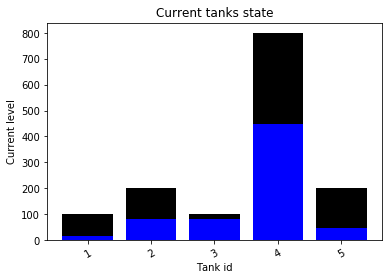

In [10]:
if train_epsilon == True and retrain == False:
    episodic_train_Q_epsilon()
elif train_epsilon == False and retrain == True:
    Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode_retrain}")
    episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
else:
    raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    
    

### Testing

In [12]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
episodes = 243000

tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


test_episodes = 10
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []

In [13]:
def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           freq = test_freq,
           test_verbose = test_verbose
           
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0      
        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                visualization_steps.append(system.visualize());

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward = system.random_action()
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, reward, " Random action is performed. Current state unknown for Q.")

            else:
                reward = system.deterministic_action(best_action)
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,reward, best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);


Test episode: 10

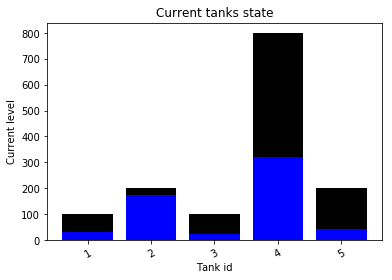

In [14]:
test_Q()
#print(np.mean(test_rewards_list) )

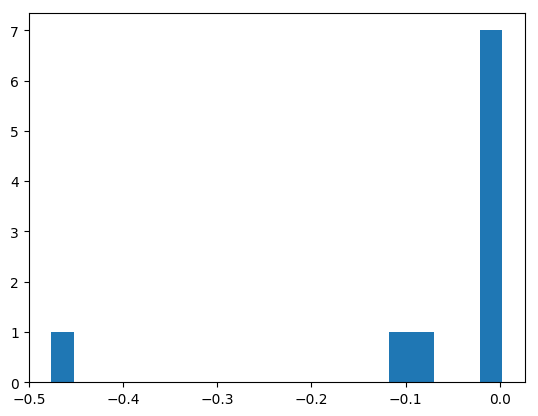

In [15]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

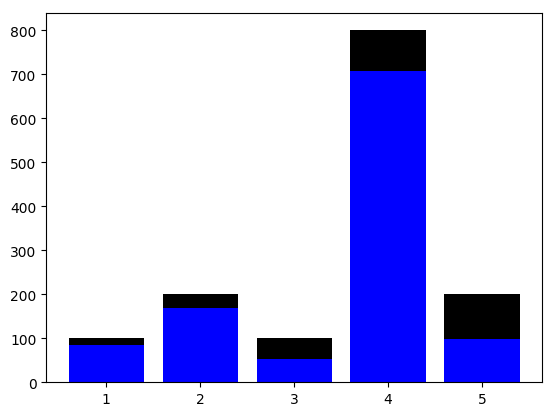

In [16]:
# Visualizing test simulation:

test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
HTML(test_anim.to_html5_video())


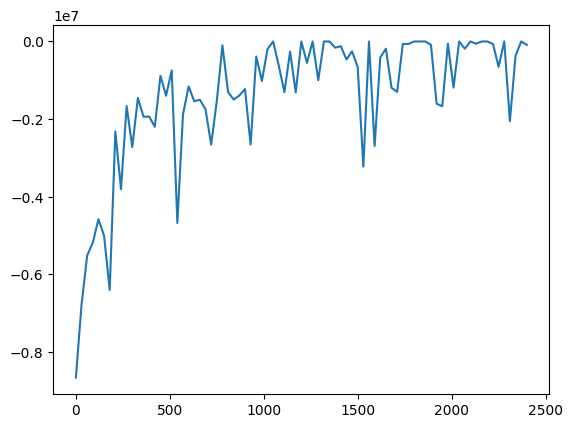

In [17]:
# Visualizing train simulation:

episode =episodes
#simulation_id = 2
step = 30
discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
             discrewards_list2)

#plt.show()
plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

In [18]:
len(list(Q))

31963

In [19]:
tank_levels = [test_visualization_steps[i][2] for i in range(len(test_visualization_steps))]
tank_levels_array = np.asarray(tank_levels).transpose()

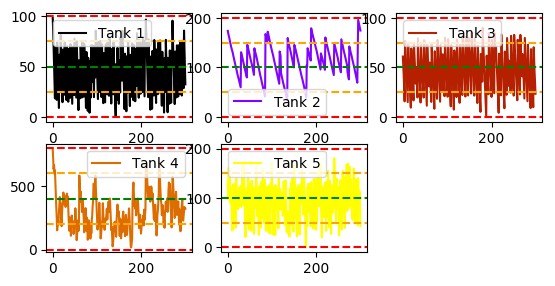

In [20]:
#DISCRETE LEVELS

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    
    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].levels):
        plt.axhline(y= lvl, xmin=0, xmax=episode_length, hold=None, color = lvl_color, linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


    plt.legend(loc='best')
plt.show()

        

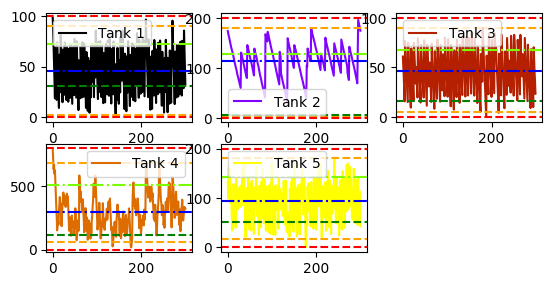

In [21]:
# THE REAL LEVELS (percentages 12h, 36h, ? h)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    

    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
        plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                    linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    
    
    percentages = tanks[i-1].level_percentages           
    c = percentages[1]
    e = percentages[2]          
    d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
    plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                linestyle = '-.')

    plt.axhline(y= np.mean(tank_levels_array[i-1]), xmin=0, xmax=episode_length, hold=None, 
                color = "blue", linestyle = '-.')
  


    plt.legend(loc='best')
#plt.show()
plt.savefig(simulation_directory + '/tank-levels-sim' + f'{simulation_id}' + '.pdf')

In [22]:
Episode: 100. Elapsed time  0.05  minuts. epsilon 0.9579 Discounted reward:  -28000041.108963497
Episode: 200. Elapsed time  0.11  minuts. epsilon 0.9187 Discounted reward:  -26000043.136069976
Episode: 300. Elapsed time  0.18  minuts. epsilon 0.8827 Discounted reward:  -20000040.21466474
Episode: 400. Elapsed time  0.27  minuts. epsilon 0.8494 Discounted reward:  -25000023.10632617
Episode: 500. Elapsed time  0.37  minuts. epsilon 0.8185 Discounted reward:  -24000028.114429202
Episode: 600. Elapsed time  0.5  minuts. epsilon 0.7898 Discounted reward:  -26000033.119467866
Episode: 700. Elapsed time  0.63  minuts. epsilon 0.763 Discounted reward:  -24000030.426938158
Episode: 800. Elapsed time  0.76  minuts. epsilon 0.7379 Discounted reward:  -22000037.105293885
Episode: 900. Elapsed time  0.88  minuts. epsilon 0.7145 Discounted reward:  -16000027.214738708
Episode: 1000. Elapsed time  1.01  minuts. epsilon 0.6925 Discounted reward:  -13000021.99472654
Episode: 1100. Elapsed time  1.16  minuts. epsilon 0.6718 Discounted reward:  -15000024.008988662
Episode: 1200. Elapsed time  1.31  minuts. epsilon 0.6524 Discounted reward:  -18000029.226717632
Episode: 1300. Elapsed time  1.47  minuts. epsilon 0.634 Discounted reward:  -19000028.52769577
Episode: 1400. Elapsed time  1.63  minuts. epsilon 0.6166 Discounted reward:  -22000036.44480863
Episode: 1500. Elapsed time  1.8  minuts. epsilon 0.6002 Discounted reward:  -12000018.0040637
Episode: 1600. Elapsed time  1.98  minuts. epsilon 0.5846 Discounted reward:  -16000031.228442688
Episode: 1700. Elapsed time  2.16  minuts. epsilon 0.5698 Discounted reward:  -23000051.112380963
Episode: 1800. Elapsed time  2.37  minuts. epsilon 0.5557 Discounted reward:  -13000020.038069973
Episode: 1900. Elapsed time  2.63  minuts. epsilon 0.5423 Discounted reward:  -21000021.34935867
Episode: 2000. Elapsed time  2.84  minuts. epsilon 0.5295 Discounted reward:  -12000014.993348014
Episode: 2100. Elapsed time  3.04  minuts. epsilon 0.5174 Discounted reward:  -13000017.050656565
Episode: 2200. Elapsed time  3.24  minuts. epsilon 0.5057 Discounted reward:  -18000029.338394843
Episode: 2300. Elapsed time  3.45  minuts. epsilon 0.4946 Discounted reward:  -9000007.996369414
Episode: 2400. Elapsed time  3.65  minuts. epsilon 0.484 Discounted reward:  -20000028.995834745
Episode: 2500. Elapsed time  3.87  minuts. epsilon 0.4738 Discounted reward:  -12000008.99960373
Episode: 2600. Elapsed time  4.09  minuts. epsilon 0.464 Discounted reward:  -8000001.990621154
Episode: 2700. Elapsed time  4.32  minuts. epsilon 0.4546 Discounted reward:  -15000022.313438928
Episode: 2800. Elapsed time  4.55  minuts. epsilon 0.4456 Discounted reward:  -11000011.050444487
Episode: 2900. Elapsed time  4.79  minuts. epsilon 0.437 Discounted reward:  -7000012.998633672
Episode: 3000. Elapsed time  5.02  minuts. epsilon 0.4287 Discounted reward:  -8000005.264682835
Episode: 3100. Elapsed time  5.27  minuts. epsilon 0.4206 Discounted reward:  -11000018.992927592
Episode: 3200. Elapsed time  5.5  minuts. epsilon 0.4129 Discounted reward:  -7000009.997351216
Episode: 3300. Elapsed time  5.77  minuts. epsilon 0.4055 Discounted reward:  -13000011.030119121
Episode: 3400. Elapsed time  6.0  minuts. epsilon 0.3983 Discounted reward:  -18000023.3058256
Episode: 3500. Elapsed time  6.24  minuts. epsilon 0.3914 Discounted reward:  -7000002.996427942
Episode: 3600. Elapsed time  6.49  minuts. epsilon 0.3847 Discounted reward:  -11000007.309740528
Episode: 3700. Elapsed time  6.75  minuts. epsilon 0.3782 Discounted reward:  -11000012.001738582
Episode: 3800. Elapsed time  7.01  minuts. epsilon 0.372 Discounted reward:  -8000003.996528433
Episode: 3900. Elapsed time  7.31  minuts. epsilon 0.3659 Discounted reward:  -9000012.050633566
Episode: 4000. Elapsed time  7.58  minuts. epsilon 0.3601 Discounted reward:  -6000005.9967362685
Episode: 4100. Elapsed time  7.85  minuts. epsilon 0.3544 Discounted reward:  -7000008.991066201
Episode: 4200. Elapsed time  8.11  minuts. epsilon 0.3489 Discounted reward:  -8000002.004340031
Episode: 4300. Elapsed time  8.39  minuts. epsilon 0.3436 Discounted reward:  -6000007.205459152
Episode: 4400. Elapsed time  8.66  minuts. epsilon 0.3384 Discounted reward:  -7000008.088827883
Episode: 4500. Elapsed time  8.92  minuts. epsilon 0.3334 Discounted reward:  -10000008.016246885
Episode: 4600. Elapsed time  9.21  minuts. epsilon 0.3285 Discounted reward:  -5000008.212606534
Episode: 4700. Elapsed time  9.51  minuts. epsilon 0.3238 Discounted reward:  -8000007.021665757
Episode: 4800. Elapsed time  9.79  minuts. epsilon 0.3192 Discounted reward:  -8000008.038475299
Episode: 4900. Elapsed time  10.07  minuts. epsilon 0.3147 Discounted reward:  -18000020.03056307
Episode: 5000. Elapsed time  10.39  minuts. epsilon 0.3104 Discounted reward:  -10000006.999470046
Episode: 5100. Elapsed time  10.76  minuts. epsilon 0.3062 Discounted reward:  -7000004.998659743
Episode: 5200. Elapsed time  11.05  minuts. epsilon 0.3021 Discounted reward:  -7000007.06712629
Episode: 5300. Elapsed time  11.38  minuts. epsilon 0.2981 Discounted reward:  -8000009.999546508
Episode: 5400. Elapsed time  11.69  minuts. epsilon 0.2942 Discounted reward:  -5000000.995678231
Episode: 5500. Elapsed time  11.99  minuts. epsilon 0.2904 Discounted reward:  -4000003.9933600356
Episode: 5600. Elapsed time  12.29  minuts. epsilon 0.2867 Discounted reward:  -11000004.996177264
Episode: 5700. Elapsed time  12.59  minuts. epsilon 0.2831 Discounted reward:  -6000003.999741462
Episode: 5800. Elapsed time  12.9  minuts. epsilon 0.2795 Discounted reward:  -2000006.9925141241
Episode: 5900. Elapsed time  13.2  minuts. epsilon 0.2761 Discounted reward:  -8000007.987305785
Episode: 6000. Elapsed time  13.54  minuts. epsilon 0.2728 Discounted reward:  -4000000.993550161

SyntaxError: invalid syntax (<ipython-input-22-cba0d1b1badc>, line 1)